In [4]:
# Grab Data
import yfinance as yf

# Common Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

In [5]:
# Download the data
# The EUR/USD exchange rate data from Yahoo Finance
data = yf.download("EURUSD=X", start="2013-01-01", end="2025-04-15")["Close"]
data.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Ticker,EURUSD=X
Date,
2013-01-01,1.320132
2013-01-02,1.319784
2013-01-03,1.318218
2013-01-04,1.303271
2013-01-07,1.306745


In [6]:
# Create a DataFrame from the Downloaded Data
raw_data = pd.DataFrame(data).reset_index()
raw_data.rename(columns={ "EURUSD=X": "Close"}, inplace=True)  # Change 'Close' to 'EURUSD=X'

# Calculate the returns and add them to the DataFrame
raw_data['Returns'] = raw_data['Close'].pct_change()

# When the market direction is greater than 0 --> class 1 (up), else class 0 (down)
raw_data['Direction'] = np.where(raw_data['Returns'] > 0, 1, 0)

raw_data.head()

Ticker,Date,Close,Returns,Direction
0,2013-01-01,1.320132,NaN,0
1,2013-01-02,1.319784,-0.000264,0
2,2013-01-03,1.318218,-0.001186,0
3,2013-01-04,1.303271,-0.011338,0
4,2013-01-07,1.306745,0.002666,1


In [7]:
# Last 5 Days of Data to predict the value
lags = 5
# Create lagged features
cols = []
for lag in range(1, lags + 1):
    col = f"lag_{lag}"
    raw_data[col] = raw_data['Returns'].shift(lag)
    cols.append(col)
raw_data.dropna(inplace=True)
raw_data.round(4).tail()

Ticker,Date,Close,Returns,Direction,lag_1,lag_2,lag_3,lag_4,lag_5
3195,2025-04-08,1.0915,-0.0063,0,-0.0054,0.0124,0.0104,-0.0021,-0.0005
3196,2025-04-09,1.0980,0.0060,1,-0.0063,-0.0054,0.0124,0.0104,-0.0021
3197,2025-04-10,1.0952,-0.0026,0,0.0060,-0.0063,-0.0054,0.0124,0.0104
3198,2025-04-11,1.1258,0.0279,1,-0.0026,0.0060,-0.0063,-0.0054,0.0124
3199,2025-04-14,1.1343,0.0076,1,0.0279,-0.0026,0.0060,-0.0063,-0.0054


### Neural Network Code using TensorFlow and Keras

In [8]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam, RMSprop
import random

In [9]:
optimizer = Adam(learning_rate=0.001)  # You can also try RMSprop or SGD
# Define the model
def set_seeds(seed =42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [10]:
set_seeds()
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(lags,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Sigmoid for binary classification
model.compile(optimizer=optimizer, 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

c:\Users\santi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
train_set, test_set = np.split(raw_data, [int(.70 * len(raw_data))])

c:\Users\santi\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [12]:
mu, std = train_set.mean(), train_set.std()

In [13]:
# Normalize the data using the Gaussian distribution
training_data_ = (train_set - mu) / std
test_data_ = (test_set - mu) / std

C:\Users\santi\AppData\Local\Temp\ipykernel_8920\832485173.py:2: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  training_data_ = (train_set - mu) / std
C:\Users\santi\AppData\Local\Temp\ipykernel_8920\832485173.py:3: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  test_data_ = (test_set - mu) / std


In [14]:
%%time
model.fit(train_set[cols], 
          train_set['Direction'],
          epochs=50, verbose=False,
          validation_split=0.2, shuffle=False)

CPU times: total: 28.7 s
Wall time: 22.8 s


In [15]:
res = pd.DataFrame(model.history.history)

<Axes: title={'center': 'Accuracy'}>

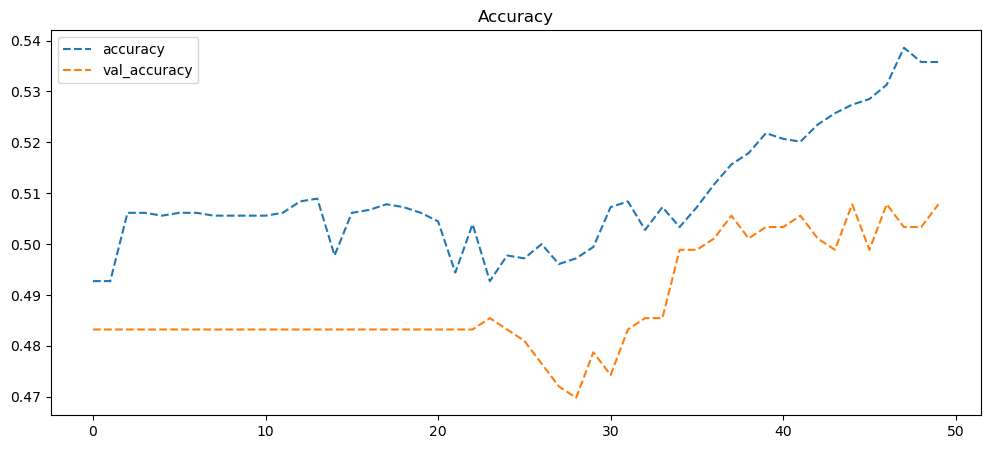

In [16]:
# Accuracy of the Model for Training and Validation Data
res[['accuracy', 'val_accuracy']].plot(title="Accuracy", figsize=(12, 5), style="--")

In [17]:
# Ensure all columns in training_data_ are numeric
training_data_[cols] = training_data_[cols].apply(pd.to_numeric)
train_set['Direction'] = pd.to_numeric(train_set['Direction'])

# Evaluate the model
model.evaluate(training_data_[cols], train_set['Direction'])

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5343 - loss: 3.9836


[3.9087703227996826, 0.5252796411514282]

In [18]:
# Creating Predictions of Market Direction
pred = np.where(model.predict(training_data_[cols]) > 0.5, 1, 0)

70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [19]:
pred[0:30].flatten()

array([0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 1])

In [20]:
# Transform the predictions to a DataFrame - Long-Short Positions: 1, -1
train_set['prediction'] = np.where(pred > 0, 1, -1)

In [21]:
train_set['Strategy'] = (train_set['prediction'] * train_set['Returns'])

In [22]:
train_set[['Returns', 'Strategy']].sum().apply(np.exp)

Ticker
Returns     0.920022
Strategy    1.673358
dtype: float64

Note: We can see that our 'strategy' outperforms the Returns benchmark

<Axes: title={'center': 'Cumulative Returns'}>

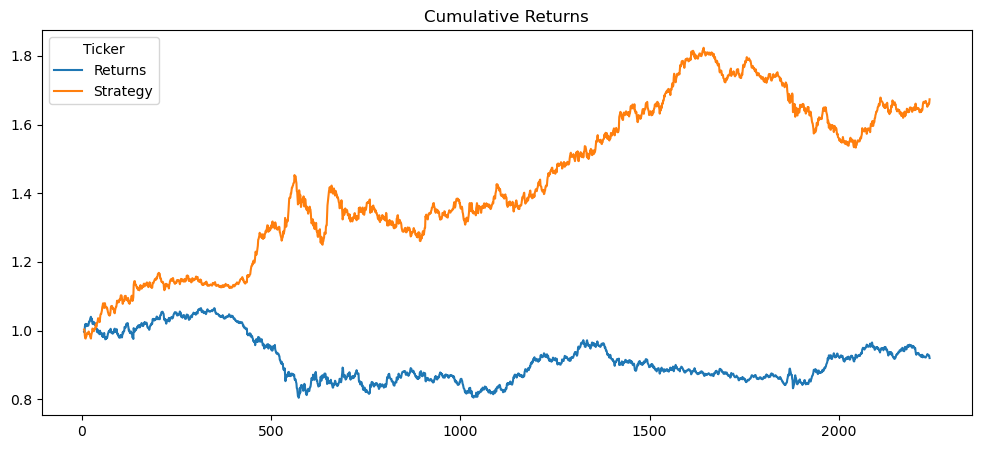

In [23]:
train_set[['Returns','Strategy']].cumsum().apply(np.exp).plot(figsize=(12, 5), title="Cumulative Returns")

### Validation Process - Out-of-Sample -> Test Set

In [24]:
# Ensure all columns in test_data_ are numeric
test_data_[cols] = test_data_[cols].apply(pd.to_numeric)
test_data_['Direction'] = pd.to_numeric(test_data_['Direction'])

# Evaluate the model
model.evaluate(test_data_[cols], test_data_['Direction'])

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0000e+00 - loss: 1.1005 


[1.0214005708694458, 0.0]

In [25]:
pred = np.where(model.predict(test_data_[cols]) > 0.5, 1, 0)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [26]:
test_set['prediction'] = np.where(pred > 0, 1, -1)

In [27]:
test_set['prediction'].value_counts()

prediction
-1    558
 1    401
Name: count, dtype: int64

In [28]:
test_set['Strategy'] = (test_set['prediction'] * test_set['Returns'])

In [29]:
test_set[['Returns', 'Strategy']].sum().apply(np.exp)

Ticker
Returns     0.976780
Strategy    0.827951
dtype: float64

<Axes: title={'center': 'Test Data - Cumulative Returns'}>

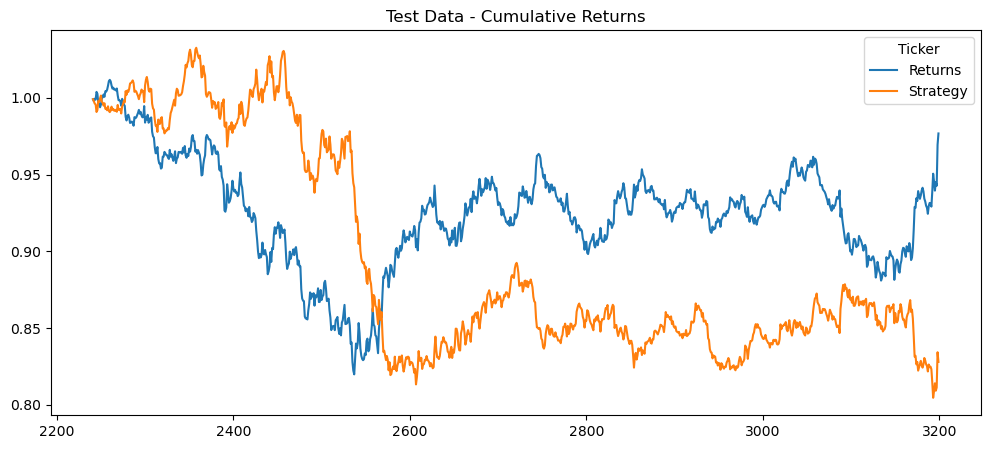

In [30]:
test_set[['Returns','Strategy']].cumsum().apply(np.exp).plot(figsize=(12, 5), title="Test Data - Cumulative Returns")

### Improving Performance of the Model - Adding Extra Features

In [31]:
# Add Momentum, Volatility & Distance to the DataFrame
raw_data['Momentum'] = raw_data['Returns'].rolling(window=5).mean().shift(1)
raw_data['Volatility'] = raw_data['Returns'].rolling(20).std().shift(1)
raw_data['Distance'] = (raw_data['Close'] - raw_data['Close'].rolling(50).mean()).shift(1)

In [32]:
raw_data.dropna(inplace=True)

In [33]:
cols.extend(['Momentum', 'Volatility', 'Distance'])

In [34]:
# New DataFrame with the new features
raw_data.round(4).tail()

Ticker,Date,Close,Returns,Direction,lag_1,lag_2,lag_3,lag_4,lag_5,Momentum,Volatility,Distance
3195,2025-04-08,1.0915,-0.0063,0,-0.0054,0.0124,0.0104,-0.0021,-0.0005,0.0030,0.0050,0.0359
3196,2025-04-09,1.0980,0.0060,1,-0.0063,-0.0054,0.0124,0.0104,-0.0021,0.0018,0.0052,0.0281
3197,2025-04-10,1.0952,-0.0026,0,0.0060,-0.0063,-0.0054,0.0124,0.0104,0.0034,0.0051,0.0335
3198,2025-04-11,1.1258,0.0279,1,-0.0026,0.0060,-0.0063,-0.0054,0.0124,0.0008,0.0051,0.0296
3199,2025-04-14,1.1343,0.0076,1,0.0279,-0.0026,0.0060,-0.0063,-0.0054,0.0039,0.0080,0.0584


In [35]:
# Refit and Train/Set
train_data, test_data = np.split(raw_data, [int(.70 * len(raw_data))])

c:\Users\santi\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [36]:
mu, std = train_data.mean(), train_data.std()

In [37]:
train_data_ = (train_data - mu) / std
test_data_ = (test_data - mu) / std

C:\Users\santi\AppData\Local\Temp\ipykernel_8920\3163597352.py:1: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  train_data_ = (train_data - mu) / std
C:\Users\santi\AppData\Local\Temp\ipykernel_8920\3163597352.py:2: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  test_data_ = (test_data - mu) / std


In [38]:
# Update Dense Layers to 32
set_seeds()
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(len(cols),)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Sigmoid for binary classification
model.compile(optimizer=optimizer, 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

c:\Users\santi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [43]:
tf.config.run_functions_eagerly(True)

In [50]:
model.evaluate(train_data[cols], train_data['Direction'])

 1/65 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.6250 - loss: 0.6930

c:\Users\santi\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\santi\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5121 - loss: 0.6931


[0.6931007504463196, 0.5262135863304138]

In [51]:
pred = np.where(model.predict(train_data_[cols]) > 0.5, 1, 0)

 1/65 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step

c:\Users\santi\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\santi\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [52]:
train_data['prediction'] = np.where(pred > 0, 1, -1)

In [53]:
train_data['Strategy'] = (train_data['prediction'] * train_data['Returns'])
train_data[['Returns', 'Strategy']].sum().apply(np.exp)

Ticker
Returns     0.844586
Strategy    1.380810
dtype: float64

<Axes: title={'center': 'Train Data - Cumulative Returns'}>

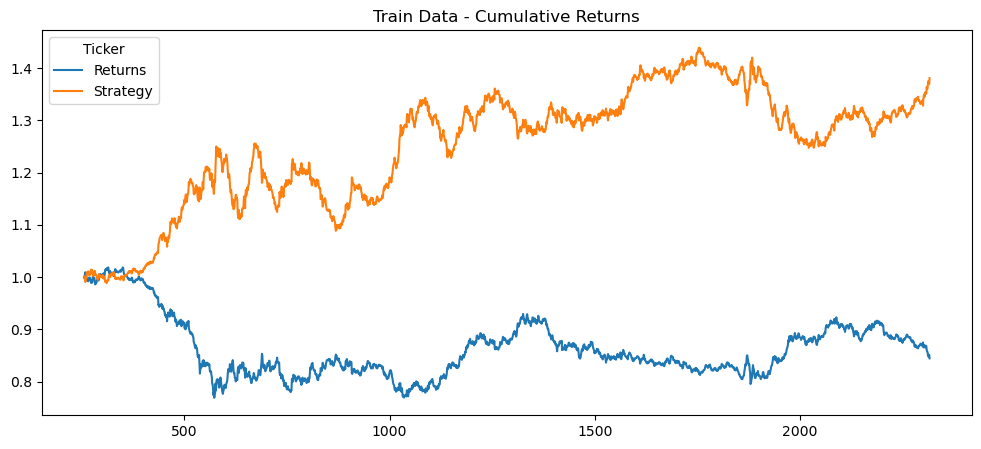

In [54]:
train_data[['Returns','Strategy']].cumsum().apply(np.exp).plot(figsize=(12, 5), title="Train Data - Cumulative Returns")

In [56]:
model.evaluate(test_data[cols], test_data['Direction'])
pred = np.where(model.predict(test_data[cols]) > 0.5, 1, 0)
test_data['prediction'] = np.where(pred > 0, 1, -1)
test_data['prediction'].value_counts()

 1/28 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.5625 - loss: 0.6930

c:\Users\santi\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\santi\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5024 - loss: 0.6931
 1/28 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step

c:\Users\santi\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\santi\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


prediction
 1    674
-1    210
Name: count, dtype: int64

In [58]:
test_set['Strategy'] = (test_set['prediction'] * test_set['Returns'])
test_set[['Returns', 'Strategy']].sum().apply(np.exp)

Ticker
Returns     0.976780
Strategy    0.827951
dtype: float64

<Axes: title={'center': 'Test Data - Cumulative Returns'}>

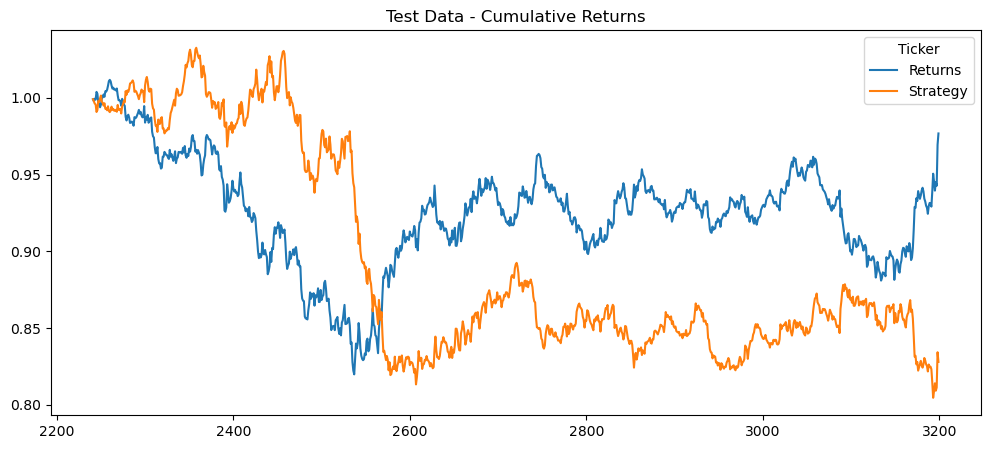

In [59]:
test_set[['Returns','Strategy']].cumsum().apply(np.exp).plot(figsize=(12, 5), title="Test Data - Cumulative Returns")